In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [10]:
# Save references to each table
Measurement = Base.classes.measurement  
Station = Base.classes.station   

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"Most recent date in the dataset: {most_recent_date}")

Most recent date in the dataset: 2017-08-23


Start date for last 12 months of data: 2016-08-23


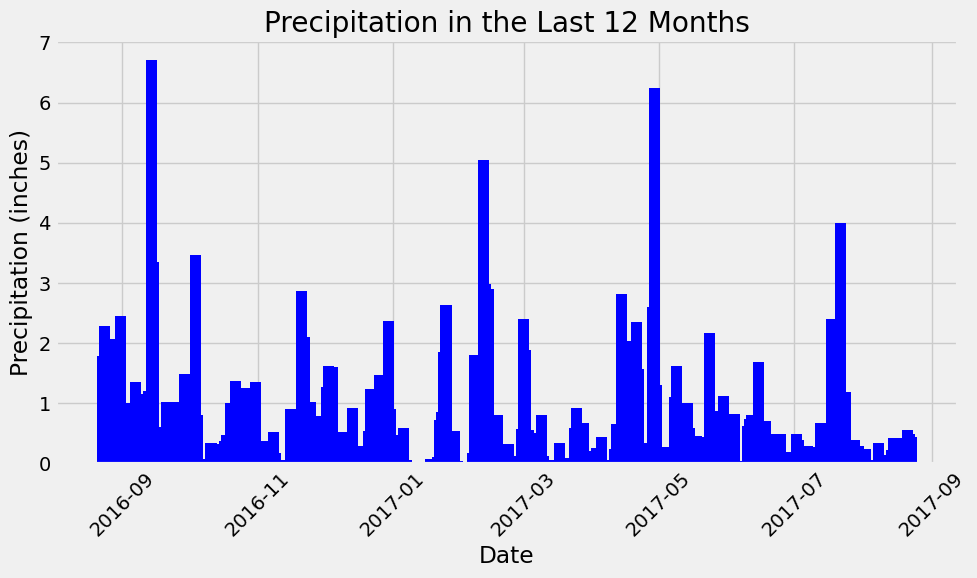

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
end_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
start_date = end_date - dt.timedelta(days=365) 
print(f"Start date for last 12 months of data: {start_date.strftime('%Y-%m-%d')}")


# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= start_date.strftime('%Y-%m-%d')
).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_precipitation = pd.DataFrame(query, columns=['date', 'precipitation'])

# Sort the dataframe by date
df_precipitation['date'] = pd.to_datetime(df_precipitation['date'])
df_precipitation.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(df_precipitation['date'], df_precipitation['precipitation'], width=5, color='blue')
plt.title('Precipitation in the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = df_precipitation['precipitation'].describe()
print(precipitation_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.id)).scalar()  
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [23]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (
    session.query(Measurement.station, func.count(Measurement.id).label('station_count'))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.id).desc())
).all()

# Print the most active stations result
print(most_active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [24]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'
temp_stats = (
    session.query(
        func.min(Measurement.tobs).label('min_temp'),
        func.max(Measurement.tobs).label('max_temp'),
        func.avg(Measurement.tobs).label('avg_temp')
    )
    .filter(Measurement.station == most_active_station_id)
).one()
print(f"Temperature Statistics for Station ID {most_active_station_id}:")
print(f"Lowest Temperature: {temp_stats.min_temp}")
print(f"Highest Temperature: {temp_stats.max_temp}")
print(f"Average Temperature: {temp_stats.avg_temp}")

Temperature Statistics for Station ID USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


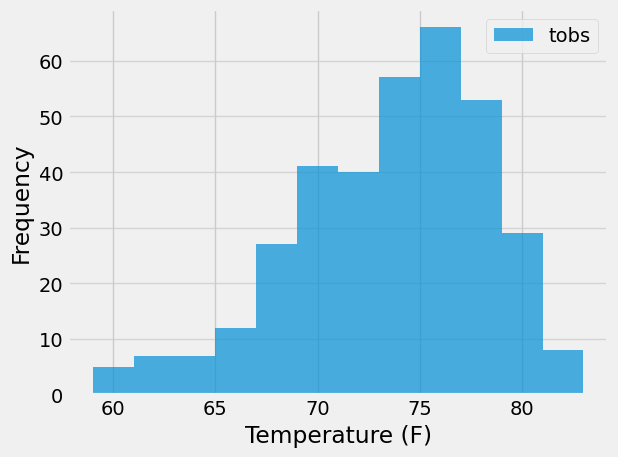

In [33]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date = session.query(func.max(Measurement.date)).scalar()
end_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
start_date = end_date - dt.timedelta(days=365)
temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= start_date.strftime('%Y-%m-%d'))
).all()
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])
plt.hist(temperature_df['tobs'], bins=12, alpha=0.7, label='tobs')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Close Session

In [34]:
# Close Session
session.close()